# Forecasting Walmart Sales with Machine Learning

In this machine learning project, we utilize historical Walmart sales data to predict store sales. The dataset can be found [here](https://www.kaggle.com/competitions/walmart-recruiting-store-sales-forecasting).

![Imgur](https://imgur.com/NqPZiq1.png)

Walmart is one of the biggest retailers and among the go-to retail stores for one's household shopping. Known for its lowest prices and cost savings across product categories, a visit to its physical stores is an experience in itself. It is a retail business that generates USD 567 billion worth of sales volume. Walmart has a Data Science and Analytics department that is dedicated to improving customer-client-employee relationships by forecasting sales, recommending products based on customer buying trends, product/customer segmentation, and several other use cases of data science.

## Problem Statement
In 2014, Walmart hosted a recruiting competition on Kaggle. Job-seekers were provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and we are tasked with predicting the department-wide sales for each store. In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

## Understand Business Requirements & Nature of Data
The business problem I am trying to solve is to forecast future sales data by training machine learning models on historical data. Sales forecasting helps every business make better business decisions. It helps in overall business planning, budgeting, and risk management. It allows companies to efficiently allocate resources for future growth and manage their cash flow. Sales forecasting also helps businesses to estimate their costs and revenue accurately based on which they are able to predict their short-term and long-term performance.

# Data download & reading with pandas

## Installing libraries

In [400]:
!pip install jovian opendatasets --upgrade --quiet

## Importing modules

In [401]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import jovian
import plotly.express as px
import os
import zipfile
import glob
%matplotlib inline
sns.set_style('darkgrid')
matplotlib.rcParams['font.size']=14
matplotlib.rcParams['figure.figsize'] = (10,8)

## Downloading the data from Kaggle

In [ ]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/competitions/walmart-recruiting-store-sales-forecasting/data'
od.download(dataset_url)

## Unzipping all the files

In [ ]:
for file in glob.glob("walmart-recruiting-store-sales-forecasting/*.zip"):
    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall("data/")

## Reading the input files with pandas

In [403]:
def return_df(file):
    
    return pd.read_csv(file, header = 0)

stores = return_df("stores.csv")
features = return_df("features.csv")
train = return_df("train.csv")
test = return_df("test.csv")

## Data files description

* stores - Type and size of 45 stores
* features - Data related to the store, department, and regional activity like fuel price, customer price index, unemployment rate, etc. for the given dates
* train - historical training data covers dates in the range 2010–02–05 to 2012–11–01.
* test - data to test the trained model on - same as train data but without the weekly sales column

In [404]:
display(stores.sample(5).sort_values(by='Store').reset_index(drop=True))

,Store,Type,Size
0,11,A,207499
1,24,A,203819
2,31,A,203750
3,39,A,184109
4,42,C,39690


In [405]:
display(features.sample(5).sort_values(by='Store').reset_index(drop=True))

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,2,2011-07-08,87.70,3.480,NaN,NaN,NaN,NaN,NaN,214.929625,7.852,False
1,2,2010-04-02,63.27,2.719,NaN,NaN,NaN,NaN,NaN,210.479887,8.200,False
2,22,2012-06-01,70.01,3.798,16432.28,7.60,73.36,3723.80,3331.57,142.109544,7.671,False
3,22,2012-03-02,37.47,3.827,28298.18,3333.76,89.58,25615.48,3141.76,141.387536,7.503,False
4,37,2012-09-28,79.49,3.666,59.61,NaN,NaN,NaN,722.92,221.655600,6.623,False


In [406]:
display(train.sample(5).sort_values(by='Store').reset_index(drop=True))

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,42,2011-03-11,8293.47,False
1,22,93,2010-08-20,2335.70,False
2,24,44,2011-04-08,4203.04,False
3,31,24,2012-05-25,4151.44,False
4,39,24,2012-04-27,5425.93,False


In [407]:
display(test.sample(5).sort_values(by='Store').reset_index(drop=True))

,Store,Dept,Date,IsHoliday
0,3,31,2013-04-26,False
1,11,13,2013-02-15,False
2,12,54,2013-07-12,False
3,34,40,2013-06-21,False
4,44,60,2013-05-10,False


## Problem Identification
Weekly_Sales is a labeled continuous numeric feature. Hence, this is an application of **Supervised ML, specifically, it is a regression problem**.

## Project Outline

1. Data Preprocessing
2. Exploratory Data Analysis
3. Preparing to Train Models
4. Implement and Train Models
5. Model Evaluation
6. Hyperparameter Tuning
7. Model Selection
8. Prediction and Analysis

# 1. Data Preprocessing

Preparing historical store sales data by cleaning, transforming, and encoding categorical variables as necessary. Perform feature engineering and feature selection. The following preprocessing tasks have been performed
* Merging stores and features data frames with train and test data with pandas merge.
* Converting boolean features to 0s and 1s
* Checking for missing/nan values

### Merging features and stores dataframe with train and test data

In [408]:
features = features.merge(stores, how = 'left', on = 'Store')

def return_merged_data(data):
    
    df = data.merge(features, how = 'left', on = ['Store','Date','IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)
    return df

In [409]:
train_data, test_data = return_merged_data(train), return_merged_data(test)

In [410]:
display(train_data.sample(5).sort_values(by = 'Store').reset_index(drop = True))

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,3,44,2011-06-17,2580.86,False,86.96,3.637,NaN,NaN,NaN,NaN,NaN,218.355175,7.574,B,37392
1,7,32,2011-10-21,3265.18,False,37.49,3.548,NaN,NaN,NaN,NaN,NaN,195.178999,8.513,B,70713
2,17,22,2011-02-18,6682.91,False,26.86,3.062,NaN,NaN,NaN,NaN,NaN,127.995250,6.866,B,93188
3,20,42,2011-06-03,10052.31,False,73.51,3.922,NaN,NaN,NaN,NaN,NaN,208.355112,7.287,A,203742
4,26,11,2012-08-03,14430.99,False,65.60,3.698,28330.0,49.21,42.09,8478.97,3544.06,138.173581,7.405,A,152513


### Converting IsHoliday boolean data to 0 if False and 1 if True

In [411]:
def convert_boolean(data):
    data['IsHoliday'] = data['IsHoliday'].map({False : 0, True : 1}).astype('int')
    return data

In [412]:
train_data, test_data = convert_boolean(train_data), convert_boolean(test_data)

### Checking for missing/nan values

In [413]:
train_data.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

The only features with missing values are MarkDown(1–5) which are anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011 and is not available for all stores all the time. Any missing value is marked with an NA. I have replaced the nan values in these columns with 0.

### Replacing nan values with 0

In [414]:
def replace_nan(data):
    
    columns_to_fill = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
    data[columns_to_fill] = data[columns_to_fill].fillna(0)
    
    return data

In [415]:
train_data, test_data = replace_nan(train_data), replace_nan(test_data)

## Feature Engineering

* From the Date column, I have extracted DayOfMonth, Month, Year, DayOfWeek, WeekOfYear, and Quarter and dropped the Date column
* Created a new column called MarkDown which is the sum of all MarkDown(1–5) columns after which those 5 columns were dropped
* In the IsHoliday column, I have changed the value to 1 for national and federal holidays as weeks with holidays might have higher sales than the weeks without holidays. Walmart could have even offered promotions during holidays.

### Extracting date information from the Date column

In [416]:
def extract_date_info(df):
    df['Date2'] = pd.to_datetime(df['Date'])

    df['Day'] = df['Date2'].dt.day.astype('int')
    df['Month'] = df['Date2'].dt.month.astype('int')
    df['Year'] = df['Date2'].dt.year.astype('int')
#     df['DayOfWeek'] = df['Date2'].dt.weekday
    df['WeekOfYear'] = df['Date2'].dt.isocalendar().week.astype('int')
    df['Quarter'] = df['Date2'].dt.quarter.astype('int')
    df = df.drop(columns = ['Date2'])


    return df

In [417]:
train_data, test_data = extract_date_info(train_data), extract_date_info(test_data)

### Data Summary Statistics

In [418]:
train_data.describe()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Day,Month,Year,WeekOfYear,Quarter
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,0.070358,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,136727.915739,15.673131,6.449510,2010.968591,25.826762,2.482767
std,12.785297,30.492054,22711.183519,0.255750,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,60980.583328,8.753549,3.243217,0.796876,14.151887,1.071341
min,1.000000,1.000000,-4988.940000,0.000000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000,1.000000,1.000000,2010.000000,1.000000,1.000000
25%,11.000000,18.000000,2079.650000,0.000000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000,8.000000,4.000000,2010.000000,14.000000,2.000000
50%,22.000000,37.000000,7612.030000,0.000000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,140167.000000,16.000000,6.000000,2011.000000,26.000000,2.000000
75%,33.000000,74.000000,20205.852500,0.000000,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,202505.000000,23.000000,9.000000,2012.000000,38.000000,3.000000
max,45.000000,99.000000,693099.360000,1.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000,31.000000,12.000000,2012.000000,52.000000,4.000000


### Adding all MarkDown(1-5) values into a new columns MarkDown

In [419]:
def markdown_info(df):
    
    # Drop rows with negative values in the specified columns
#     negative_mask = (df['MarkDown1'] < 0) | (df['MarkDown2'] < 0) | (df['MarkDown3'] < 0) | (df['MarkDown4'] < 0) | (df['MarkDown5'] < 0)
#     df = df[~negative_mask].copy()

    # Create a new column 'MarkDown' with the sum of values from the 5 columns
    df['MarkDown'] = df['MarkDown1'] + df['MarkDown2'] + df['MarkDown3'] + df['MarkDown4'] + df['MarkDown5']
    df.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], axis=1, inplace=True)
    
    return df

In [420]:
train_data, test_data = markdown_info(train_data), markdown_info(test_data)

### Add national holiday information

Common week numbers for holidays in all four years:

- Week 1: New Year's Day (2010, 2011, 2012, 2013)
- Week 6: Super Bowl
- Week 47: Thanksgiving Day (2010, 2011, 2012)
- Week 52: Christmas Day (2010, 2011, 2012, 2013)

In [421]:
def isholiday(df):
    
    holiday_weeks = [1, 6, 36, 47, 52]
    df.loc[df['WeekOfYear'].isin(holiday_weeks), 'IsHoliday'] = 1
    
    return df

In [422]:
train_data, test_data = isholiday(train_data), isholiday(test_data)

### Taking only those rows into consideration where weekly sales is positive

In [423]:
train_data = train_data[train_data['Weekly_Sales'] > 0]

### Sorting the training data by Date

In [424]:
train_data = train_data.sort_values(by=['Date']).reset_index(drop=True)

# 2. Exploratory Data Analysis

### Let us explore the trends between several input columns and target column Weeky_Sales

### Visualizing heatmap of correlation matrix

In [425]:
numeric_cols = ['Store', 'Dept', 'IsHoliday', 'Temperature','Fuel_Price', 'CPI', 'Unemployment', 'Size', 'Day', 'Month','Year', 'WeekOfYear', 'Quarter', 'MarkDown','Weekly_Sales']

<Axes: >

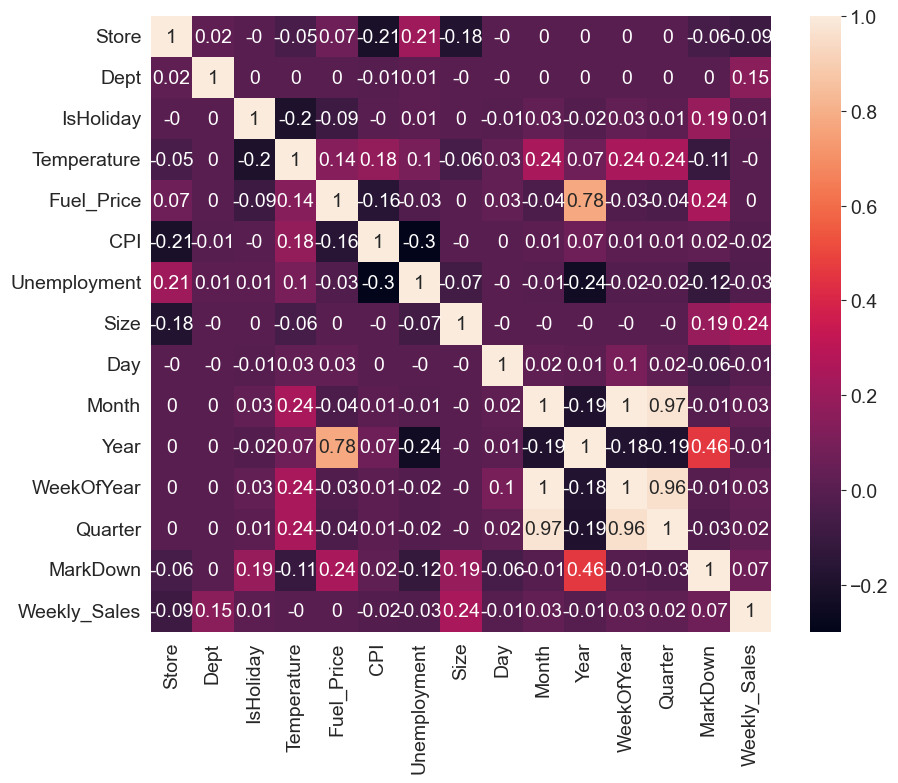

In [426]:
sns.heatmap(train_data[numeric_cols].corr().round(decimals=2), annot = True)

**Insights** - Size and Department seem to have the highest correlation with Weekly_Sales

### What is the trend in sales through all the weeks of the year?

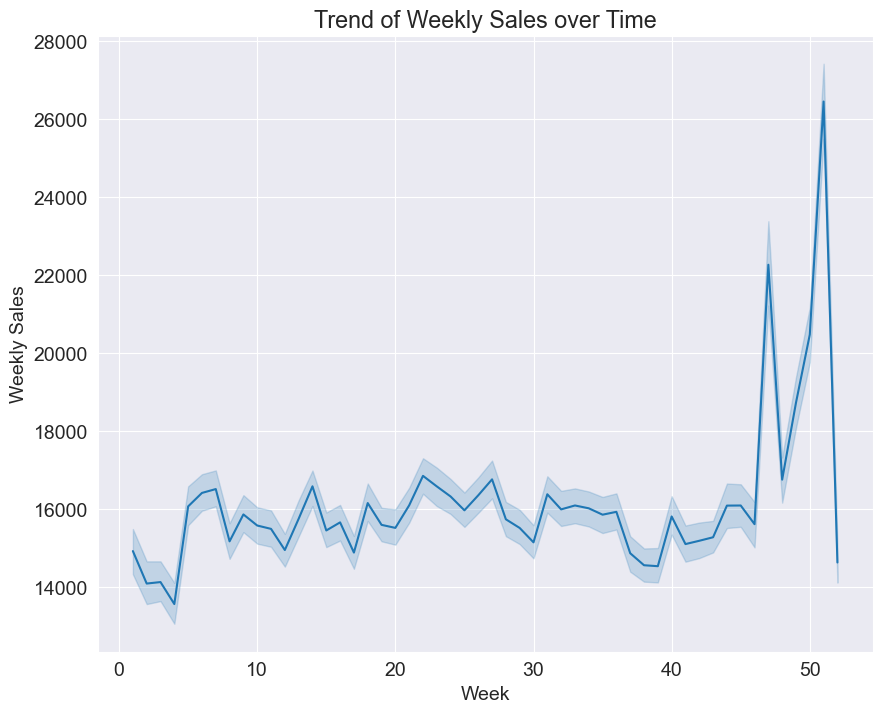

In [427]:
sns.lineplot(data=train_data, x='WeekOfYear', y='Weekly_Sales')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title('Trend of Weekly Sales over Time')
plt.show()

**Insights** - There seems to be a major spike during Thanksgiving and Chrismas weeks

### How does weekly sales look like for different stores?

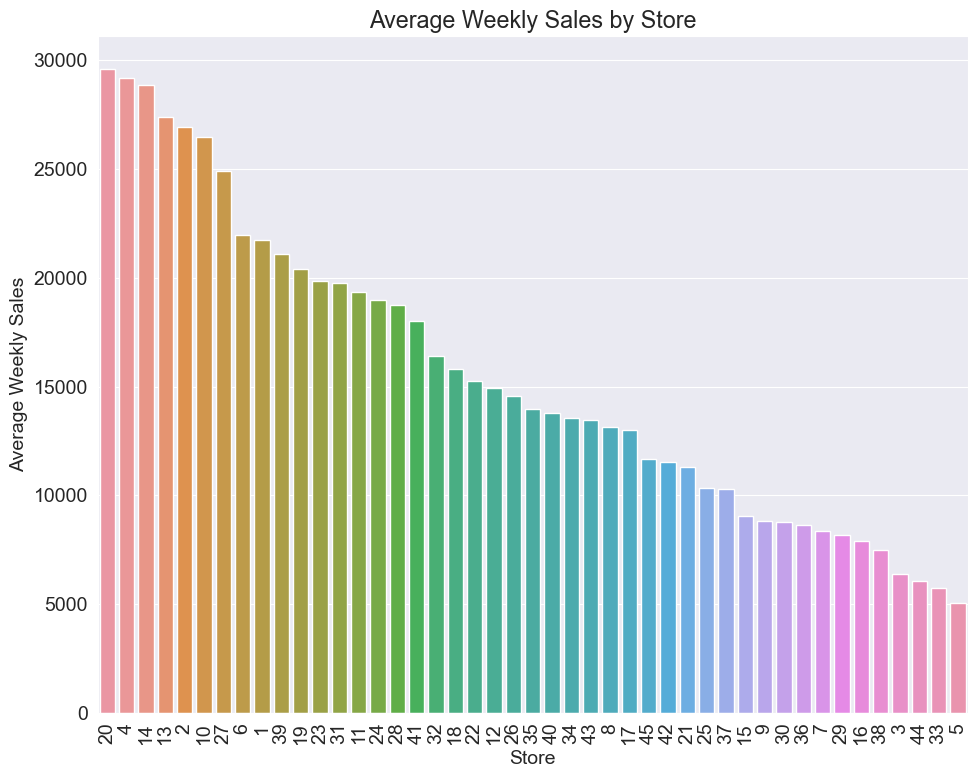

In [428]:
avg_sales_by_store = train_data.groupby('Store')['Weekly_Sales'].mean().reset_index()
sns.barplot(data=avg_sales_by_store, x='Store', y='Weekly_Sales', 
            order = avg_sales_by_store.sort_values('Weekly_Sales',ascending = False)['Store'])
plt.xlabel('Store')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales by Store')
plt.xticks(rotation=90)  # Rotate X-axis labels by 45 degrees
plt.tight_layout()  # Adjust layout to prevent label overlapping
plt.show()

**Insights** - The top 5 stores with high average weekly sales are 20,4,14,13,2

### Does temperature of the day drive sales?

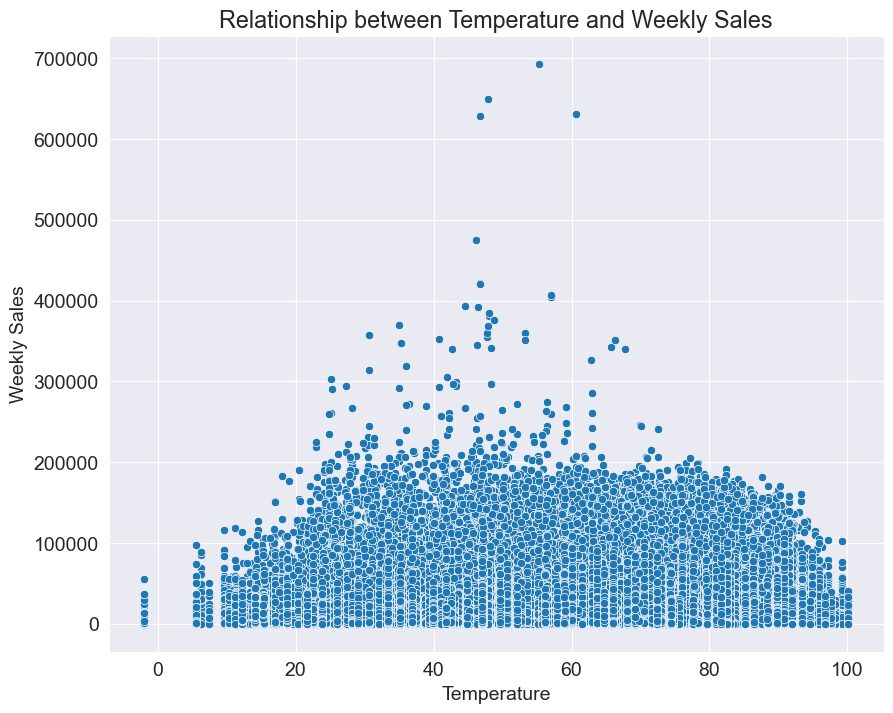

In [429]:
sns.scatterplot(data=train_data, x='Temperature', y='Weekly_Sales')
plt.xlabel('Temperature')
plt.ylabel('Weekly Sales')
plt.title('Relationship between Temperature and Weekly Sales')
plt.show()

**Inights** - High weekly sales seem to be recorded when temperatures are pleasant - in the range 30-70 Fahrenheit

### Does store type have any trend with weekly sales?

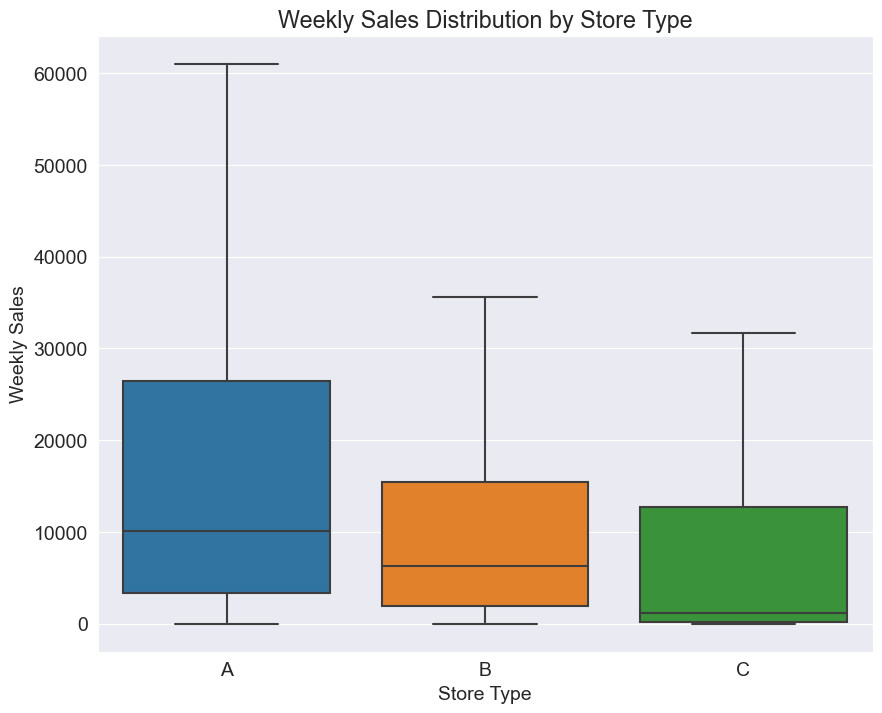

In [430]:
sns.boxplot(data=train_data, x='Type', y='Weekly_Sales',showfliers = False)
plt.xlabel('Store Type')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Distribution by Store Type')
plt.show()

**Insights** - Store Type A seems to have higher weekly sales, followed by B and then C

### What is the average weekly sales month-wise?

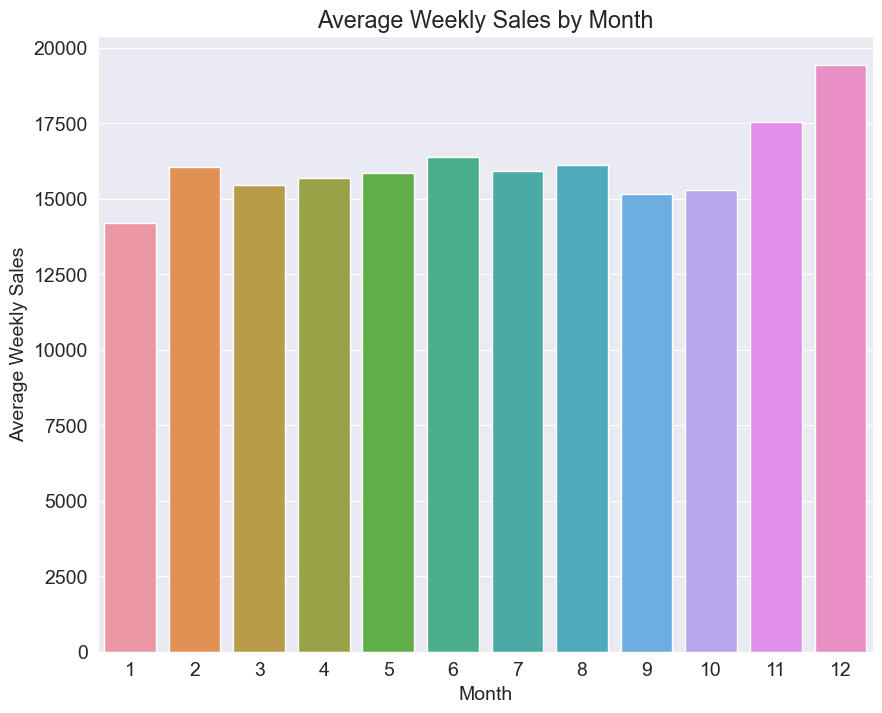

In [431]:
avg_sales_by_month = train_data.groupby('Month')['Weekly_Sales'].mean().reset_index()
sns.barplot(data=avg_sales_by_month, x='Month', y='Weekly_Sales')
plt.xlabel('Month')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales by Month')
plt.show()

**Insights** - Months 11 and 12 seem to have highest recorded weekly sales.

### Relation between store size and weekly sales?

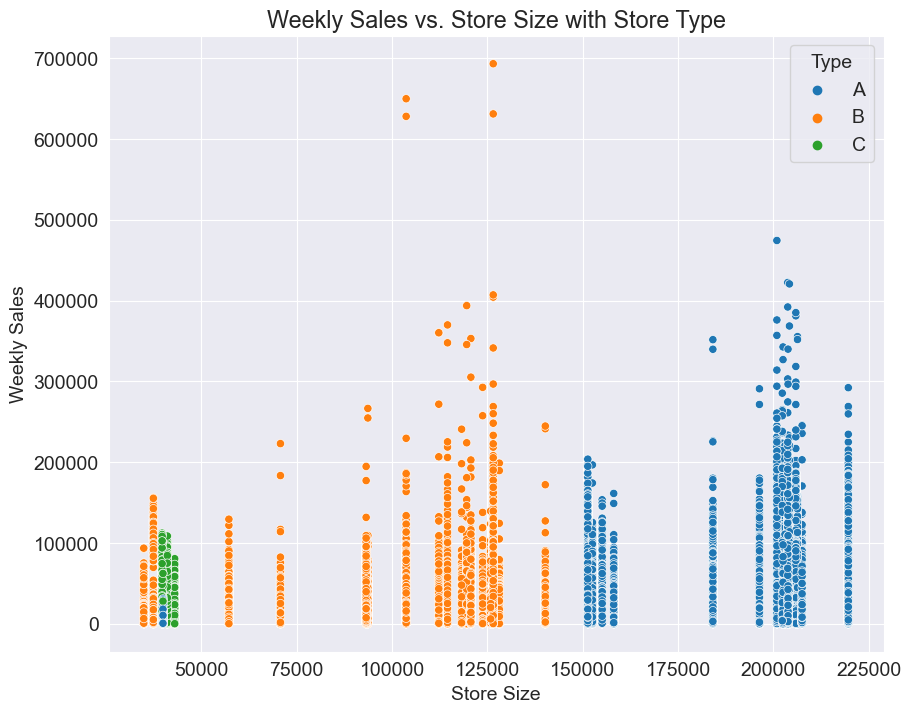

In [432]:
sns.scatterplot(data=train_data, x='Size', y='Weekly_Sales', hue='Type')
plt.xlabel('Store Size')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales vs. Store Size with Store Type')
plt.show()

**Insights** - Store type A are bigger Walmarts and therefore it makes sense that they record highest weekly sales

### Weekly sales for holiday vs. non-holiday weeks

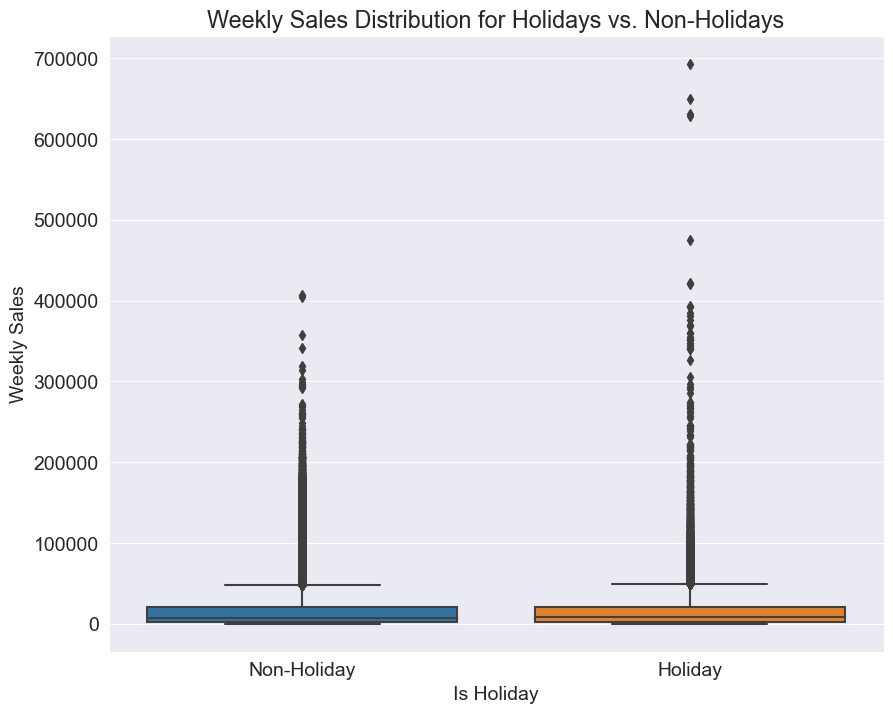

In [433]:
sns.boxplot(data=train_data, x='IsHoliday', y='Weekly_Sales')
plt.xlabel('Is Holiday')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Distribution for Holidays vs. Non-Holidays')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.show()

**Insights** - Holiday weeks have more high weekly sales outliers compared to non-holiday weeks

### average weekly sales for all the years

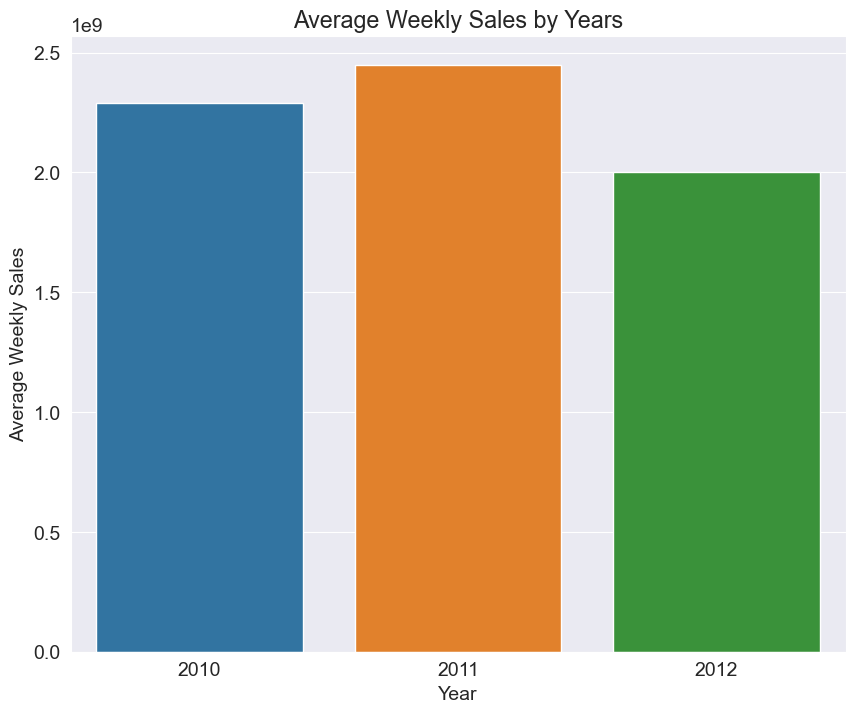

In [434]:
avg_sales_by_year = train_data.groupby('Year')['Weekly_Sales'].sum().reset_index()
# Plot the average weekly sales by years
sns.barplot(data=avg_sales_by_year, x='Year', y='Weekly_Sales')
plt.xlabel('Year')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales by Years')
plt.show()

**Insights** - 2011 is the year that has recorded highest weekly sales

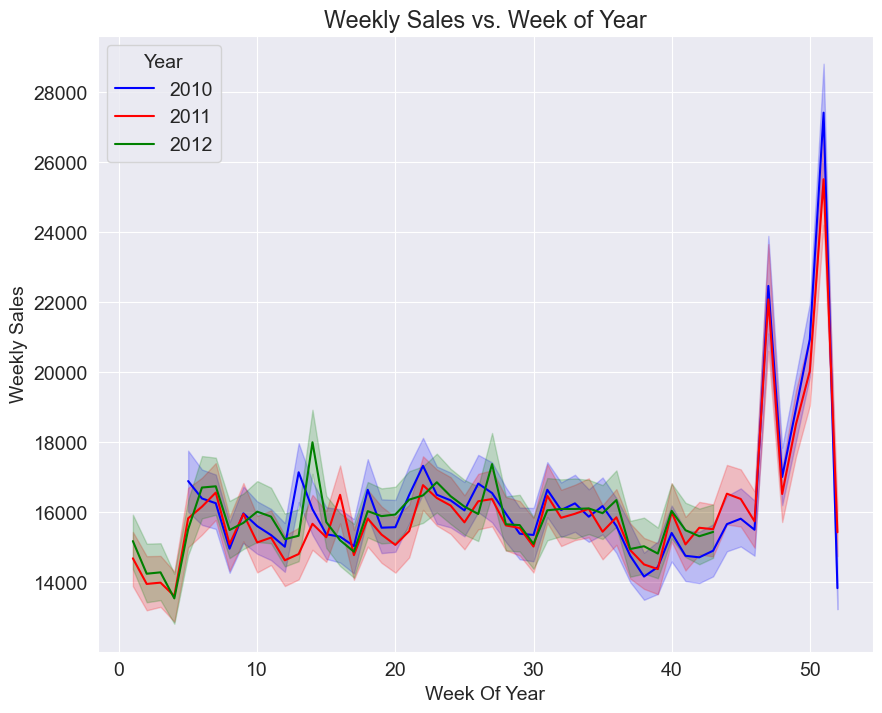

In [435]:
sns.lineplot(train_data, x = 'WeekOfYear', y = 'Weekly_Sales', hue = 'Year', palette = ['blue', 'red', 'green'])
plt.xlabel('Week Of Year')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales vs. Week of Year')
plt.show()

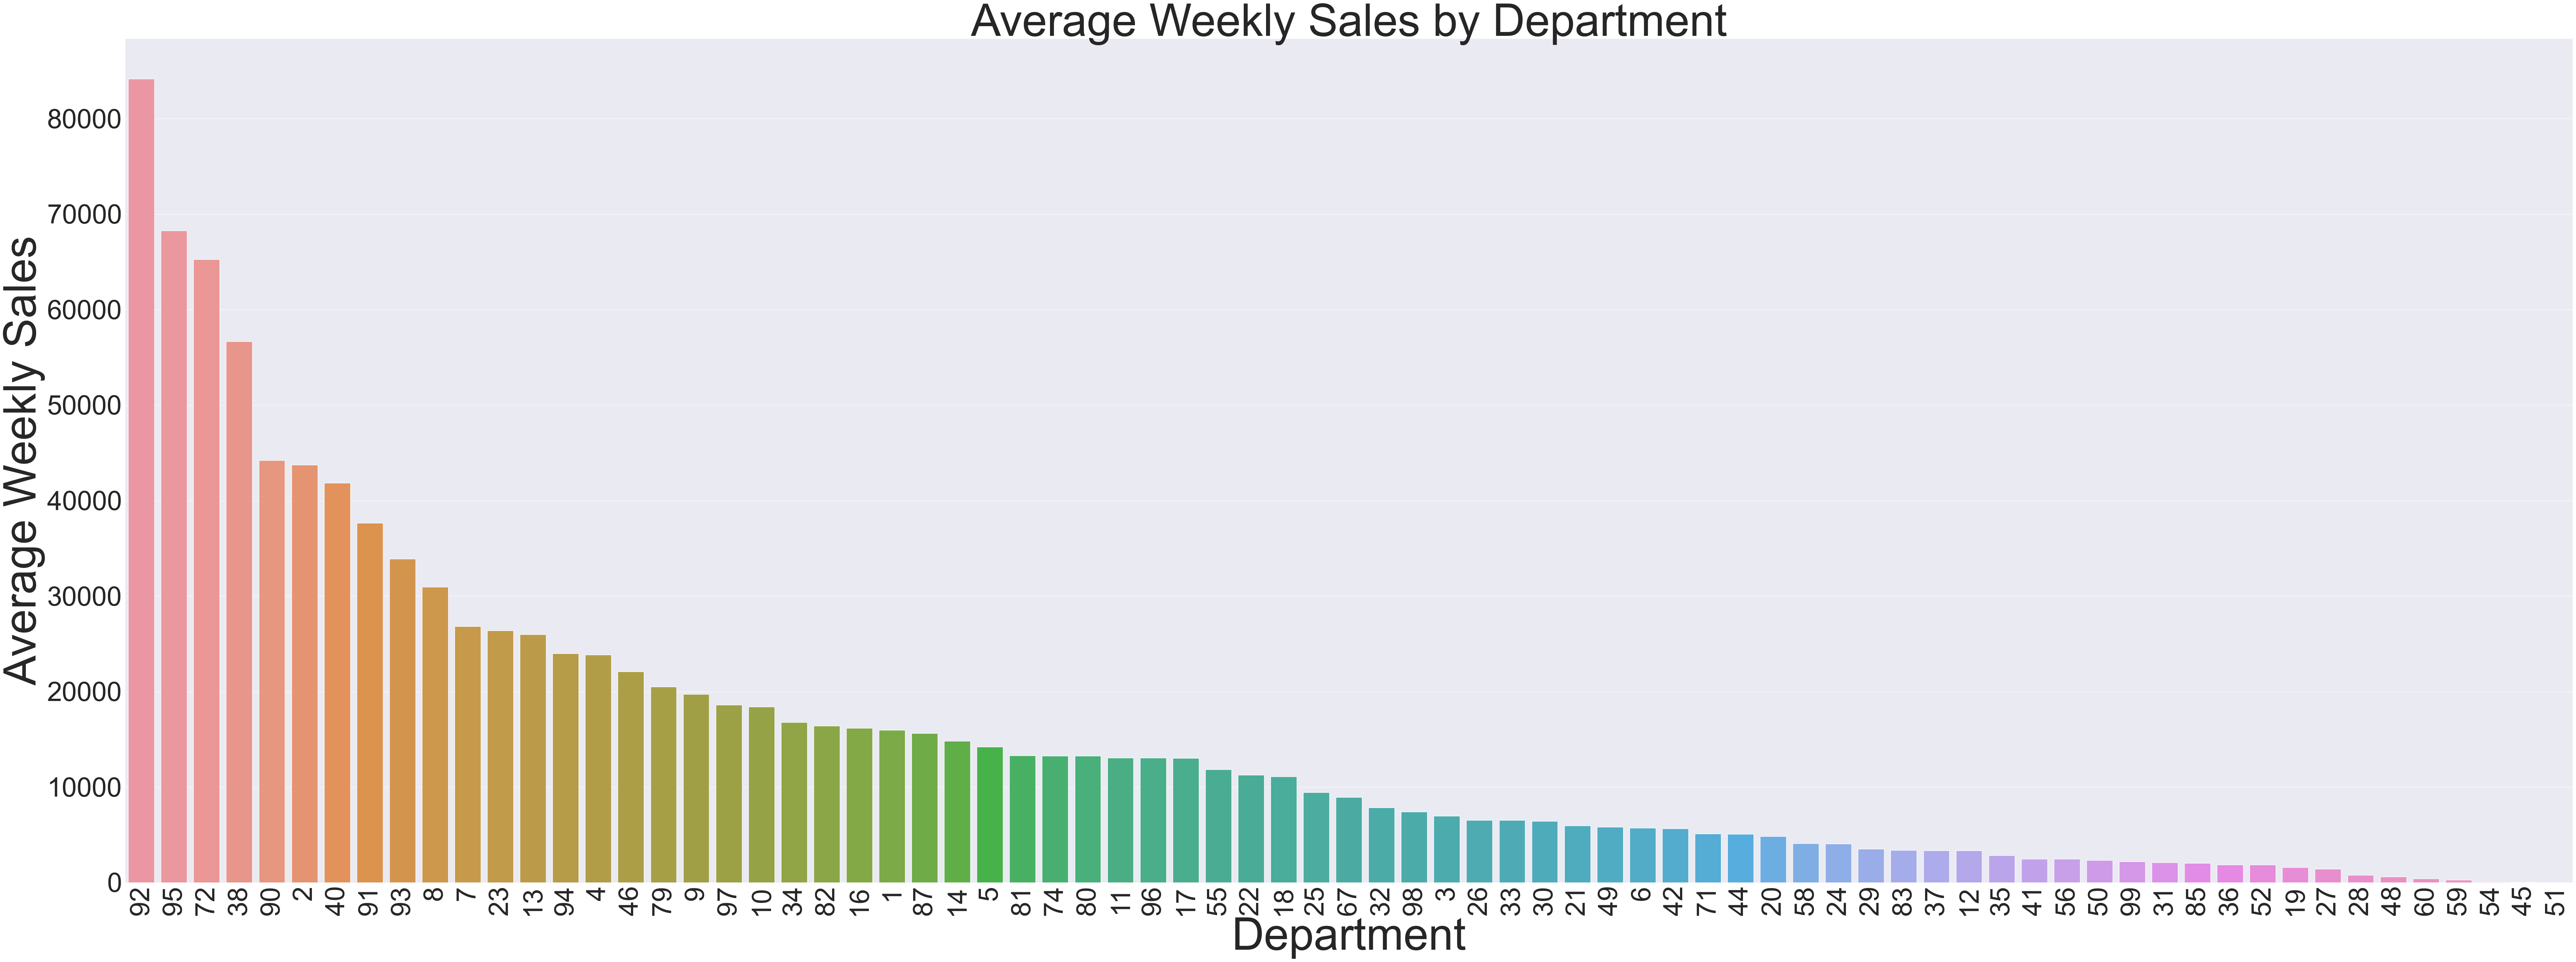

In [436]:
avg_sales_by_store = train_data.sample(1000).groupby(['Dept'])['Weekly_Sales'].mean().reset_index()
plt.figure(figsize = (80,30))
sns.barplot(data=avg_sales_by_store, x='Dept', y='Weekly_Sales', order = avg_sales_by_store.sort_values('Weekly_Sales',ascending = False)['Dept'])
plt.xlabel('Department', fontsize = 100)
plt.ylabel('Average Weekly Sales', fontsize = 100)
plt.title('Average Weekly Sales by Department', fontsize = 100)
plt.yticks(fontsize=60)
plt.xticks(fontsize=60)
plt.xticks(rotation=90)  # Rotate X-axis labels by 45 degrees
plt.tight_layout()  # Adjust layout to prevent label overlapping
plt.show()

**Insights** - Top 5 performing departments are 95,38,40,92,90 

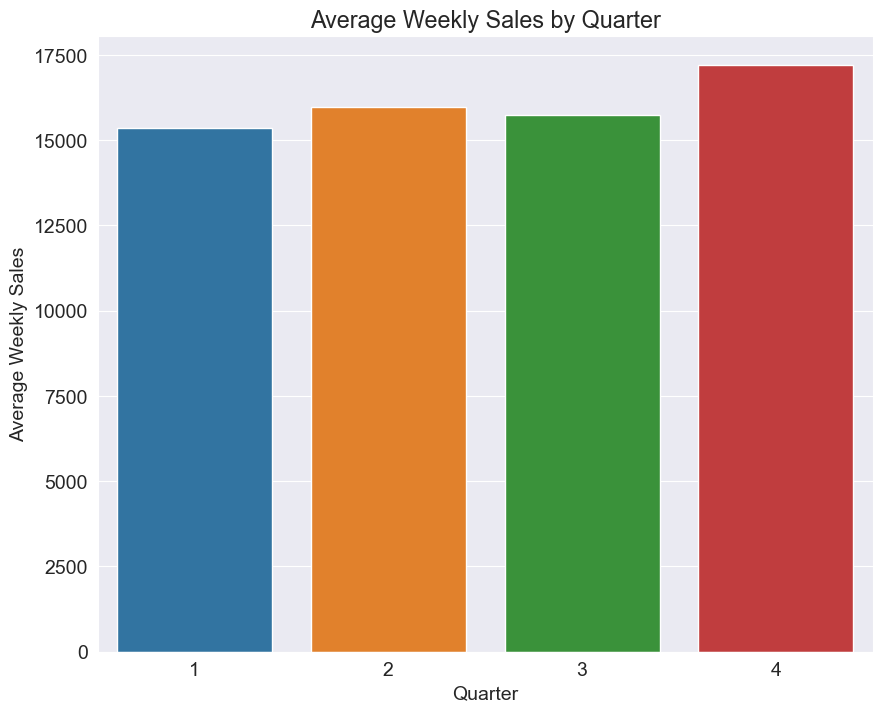

In [437]:
avg_sales_by_month = train_data.groupby('Quarter')['Weekly_Sales'].mean().reset_index()
sns.barplot(data=avg_sales_by_month, x='Quarter', y='Weekly_Sales')
plt.xlabel('Quarter')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales by Quarter')
plt.show()

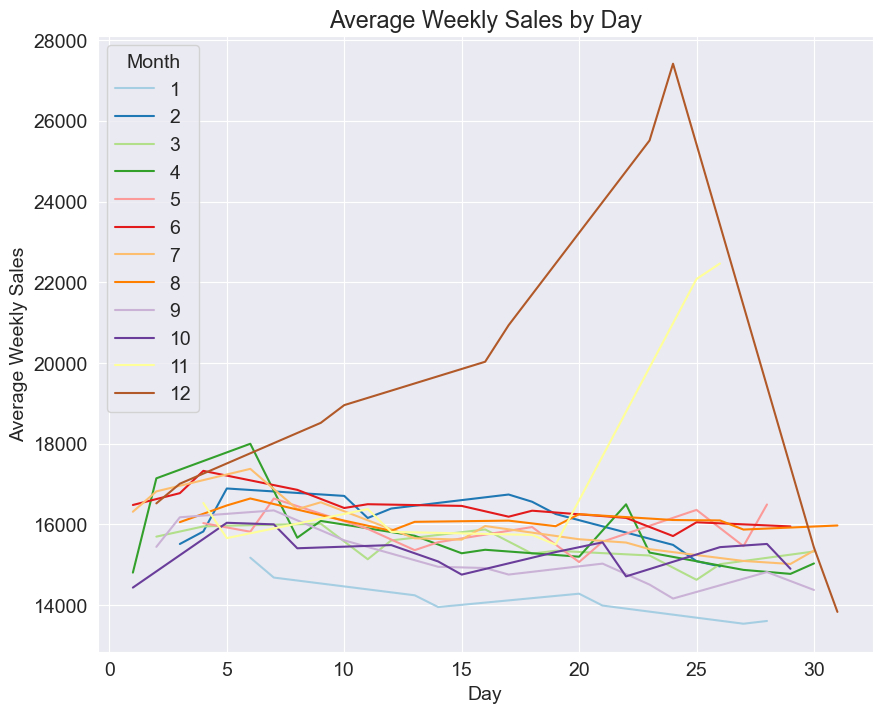

In [438]:
avg_sales_by_month = train_data.groupby(['Day', 'Month'])['Weekly_Sales'].mean().reset_index()
sns.lineplot(data=avg_sales_by_month, x='Day', y='Weekly_Sales', hue = 'Month', palette = sns.color_palette("Paired", 12))
plt.xlabel('Day')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales by Day')
plt.show()

**Insights** - There is a huge spike around Christmas

# 3. Preparing to train ML models
In this section, I have performed the following tasks
* Splitting that data into train and validation sets (75–25 split)
* Identifying input and target columns
* Identifying numeric and categorical columns
* Imputation, Scaling, and Encoding

### Splitting given train data into training and validation data

We will do a rough 75-25 split for the training and validation data.

In [439]:
train_size = int(.75 * len(train_data))
train_df,val_df = train_data[:train_size], train_data[train_size:]

In [440]:
len(train_df), len(val_df)

(315159, 105053)

### Identifying input and target columns

In [441]:
input_cols = ['Store', 'Dept', 'IsHoliday', 'Temperature','Fuel_Price', 'CPI', 'Unemployment', 'Type', 'Size', 'Day', 'Month','Year', 'WeekOfYear', 'Quarter', 'MarkDown']
target_col = 'Weekly_Sales'

In [442]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

test_inputs = test_data[input_cols].copy()

### Identifying numeric and categorical columns

In [443]:
def num_cat_cols(data):
    
    numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = data.select_dtypes('object').columns.tolist()
    
    return numeric_cols, categorical_cols

In [444]:
numeric_cols, categorical_cols = num_cat_cols(train_inputs)

### Imputation, Scaling and Encode

In [445]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
imputer = SimpleImputer(strategy='mean').fit(train_inputs[numeric_cols])
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

scaler = MinMaxScaler().fit(train_inputs[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(train_inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

X_train = train_inputs[numeric_cols+encoded_cols]
X_val = val_inputs[numeric_cols+encoded_cols]
X_test = test_inputs[numeric_cols+encoded_cols]

# 4.  Implement and Train ML models

#### Baseline ML model - Linear models
Since this is a regression problem, I shall set LinearRegression() model as my baseline ML model. 

I have additionally trained Ridge, Lasso, ElasticNet, and SGDRegressor in order to conduct a comprehensive comparison of the performance of all linear models offered by Sklearn. 

I have created a function try_linear_models(model) that takes in the model as input, performs training on training data, and returns the training and validation root mean squared errors.

In [446]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

In [447]:
linear_models_scores = {}

In [448]:
def try_linear_models(model_name, model):
    
    model.fit(X_train, train_targets) # training the model on training data
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val) # model predictions on validation data
    
    # Training prediction scores
    train_mae = mean_absolute_error(train_targets, train_preds)
    train_rmse = mean_squared_error(train_targets, train_preds, squared=False)
    train_r2 = r2_score(train_targets, train_preds)
    # validation prediction scores
    val_mae = mean_absolute_error(val_targets, val_preds)
    val_rmse = mean_squared_error(val_targets, val_preds, squared=False)
    val_r2 = r2_score(val_targets, val_preds)
    
    linear_models_scores[model_name] = {'mae':[round(train_mae,2), round(val_mae,2)],'rmse':[round(train_rmse,2), round(val_rmse,2)],'r2':[round(train_r2,2), round(val_r2,2)]}
    
    return val_mae, val_rmse, val_r2

In [449]:
model_names = ['linear', 'ridge', 'lasso', 'elasticnet', 'sgd']
models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), SGDRegressor()]

for i in range(len(models)):
    
    val_mae, val_rmse, val_r2 = try_linear_models(model_names[i], models[i])

In [450]:
pd.DataFrame(linear_models_scores)

,linear,ridge,lasso,elasticnet,sgd
mae,"[14610.62, 14416.66]","[14610.46, 14410.3]","[14609.78, 14409.66]","[14857.83, 14743.27]","[14842.92, 14716.8]"
rmse,"[21897.48, 20997.08]","[21897.78, 20995.76]","[21898.1, 20995.46]","[22466.83, 21587.16]","[21909.39, 21011.37]"
r2,"[0.09, 0.1]","[0.09, 0.1]","[0.09, 0.1]","[0.04, 0.04]","[0.09, 0.09]"


We see that the linear models on average returns RMSE scores of ~$20,000. This is a very poor performance by our baseline ML models as ~20,000 is around the 75th percentile of weekly sales. The model r2 score is very low and therefore I do not find it necessary to investigate the linear models further.

### Ensemble Models
I have trained ensemble models like random forest, gradient boosting, adaboost, XGBoost, and LightGBM with default parameters as an initial check to see which models have better evaluation score. I have created a function try_ensemble_methods() which takes in the model as input and returns the evaluation metrics.

In [451]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [452]:
rf_scores = {}
gb_scores = {}
ab_scores = {}
xgb_scores = {}
lgbm_scores = {}
trained_models = {}

In [453]:
def try_ensemble_methods(model_name, model, score_dict):
    
    model.fit(X_train, train_targets.values.ravel())
    
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    
    # Training prediction scores
    train_mae = mean_absolute_error(train_targets, train_preds)
    train_rmse = mean_squared_error(train_targets, train_preds, squared=False)
    train_r2 = r2_score(train_targets, train_preds)
    # validation prediction scores
    val_mae = mean_absolute_error(val_targets, val_preds)
    val_rmse = mean_squared_error(val_targets, val_preds, squared=False)
    val_r2 = r2_score(val_targets, val_preds)
    
    score_dict['mae'] = {'training':round(train_mae,2), 'validation': round(val_mae,2)}
    score_dict['rmse'] = {'training':round(train_rmse,2), 'validation': round(val_rmse,2)}
    score_dict['r2'] = {'training':round(train_r2,2), 'validation': round(val_r2,2)}
    
    trained_models[model_name] = model
    
    return val_mae, val_rmse, val_r2

In [454]:
ensemble_models = [RandomForestRegressor(random_state=42, n_jobs=-1),
                  GradientBoostingRegressor(random_state=42),
                  AdaBoostRegressor(random_state=42),
                  XGBRegressor(random_state=42, n_jobs=-1),
                  LGBMRegressor(random_state=42, n_jobs=-1)]
ensemble_model_names = ['random_forest','gradient_boosting',
                       'adaboost','xgboost','lightgbm']
score_dicts = [rf_scores,gb_scores, ab_scores, xgb_scores, lgbm_scores]


for i in range(5):
    
    val_mae, val_rmse, val_r2 = try_ensemble_methods(ensemble_model_names[i], ensemble_models[i], score_dicts[i])
    print("*********")
    print(ensemble_model_names[i])
    print("Val MAE: ", val_mae)
    print("Val RMSE: ", val_rmse)
    print("Val R2: ", val_r2)

*********
random_forest
Val MAE:  1972.73927486126
Val RMSE:  4293.76945097734
Val R2:  0.9621713170910176
*********
gradient_boosting
Val MAE:  6599.888238020384
Val RMSE:  10390.931194099461
Val R2:  0.778459712408722
*********
adaboost
Val MAE:  18335.0794120106
Val RMSE:  22224.678093018403
Val R2:  -0.013478956504596962
*********
xgboost
Val MAE:  3326.0800714051434
Val RMSE:  5480.708662594418
Val R2:  0.9383664460585117
*********
lightgbm
Val MAE:  4175.374835228325
Val RMSE:  6710.251528702608
Val R2:  0.9076107638701445


# 5. Model Evaluation

In [455]:
print("Random Forest scores")
display(pd.DataFrame(rf_scores))
print("XGBoost Scores")
display(pd.DataFrame(xgb_scores))
print("LightGBM Scores")
display(pd.DataFrame(lgbm_scores))
print("Gradient Boosting Scores")
display(pd.DataFrame(gb_scores))
print("AdaBoost Scores")
display(pd.DataFrame(ab_scores))

Random Forest scores


,mae,rmse,r2
training,493.43,1285.99,1.00
validation,1972.74,4293.77,0.96


XGBoost Scores


,mae,rmse,r2
training,2962.67,5084.61,0.95
validation,3326.08,5480.71,0.94


LightGBM Scores


,mae,rmse,r2
training,4095.20,6717.26,0.91
validation,4175.37,6710.25,0.91


Gradient Boosting Scores


,mae,rmse,r2
training,6881.98,11743.40,0.74
validation,6599.89,10390.93,0.78


AdaBoost Scores


,mae,rmse,r2
training,19386.34,23509.50,-0.05
validation,18335.08,22224.68,-0.01


### Feature importance

In [456]:
rf = trained_models['random_forest']
xgb = trained_models['xgboost']
lgbm = trained_models['lightgbm']

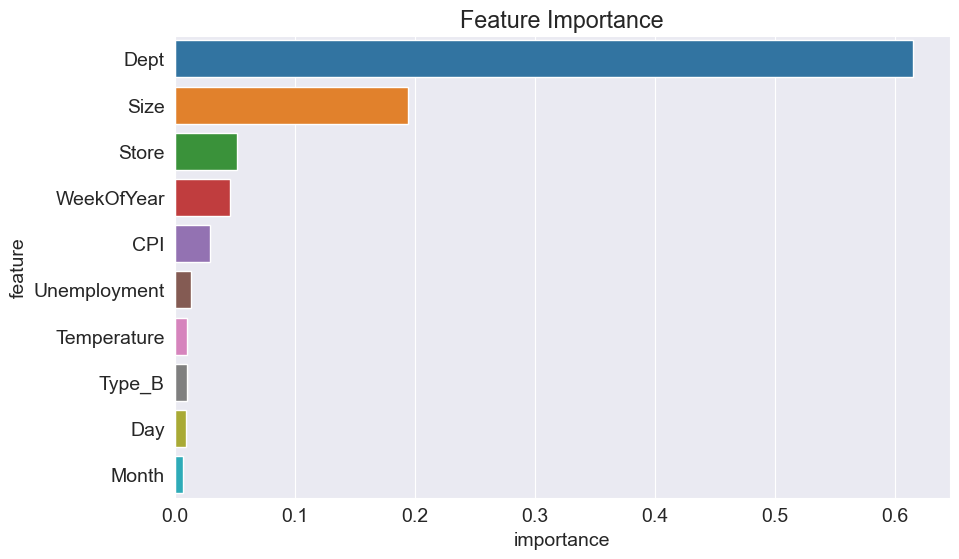

In [457]:
rf_imp_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=rf_imp_df.head(10), x='importance', y='feature');

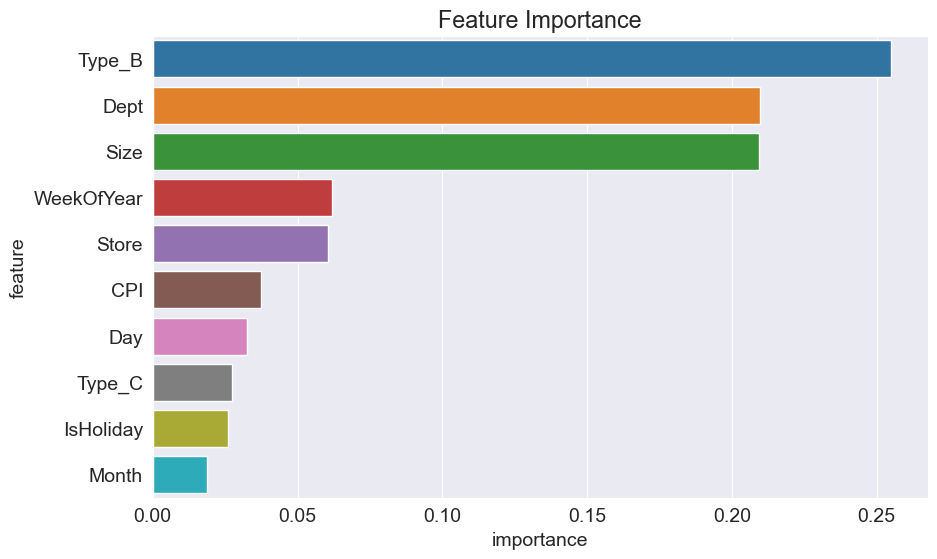

In [458]:
xgb_imp_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=xgb_imp_df.head(10), x='importance', y='feature');

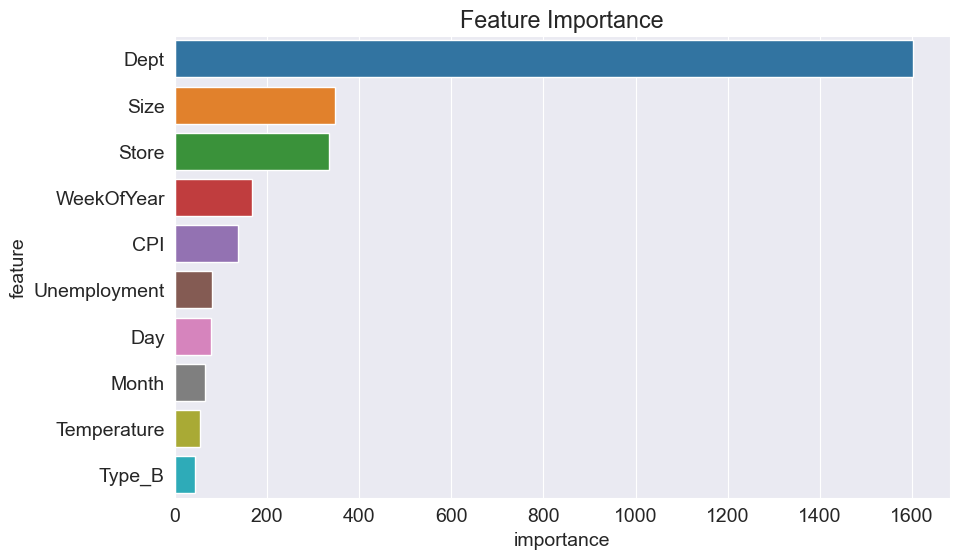

In [459]:
lgbm_imp_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=lgbm_imp_df.head(10), x='importance', y='feature');

Dept and Size are the two most important features that determine weekly sales

### The top 3 performing models are Random Forest, XGBoost and LightGBM. I shall now perform Hyperparameter tuning on these models

# 6. Hyperparameter Tuning

The hyperparameter tuning is evaluated based on weighted mean absolute error (WMAE).

$ WMAE = \frac{1}{\sum w_i} \sum_{i=1}^{n} w_i |y_i - \hat{y}_i| $

where,
- n : number of rows
- $ \hat{y}_i $ : predicted sales
- $y_i$ : actual sales
- $w_i$ : weights. w = 5 if the week is a holiday week, 1 otherwise

In [460]:
def weighted_mean_absolute_error(y_true, y_pred, weights):
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

In [461]:
# Creating the weights
train_weights = np.where(X_train['IsHoliday'] == 1, 5, 1)
val_weights = np.where(X_val['IsHoliday'] == 1, 5, 1)

In [462]:
models = {
    'randomforest': {
        'model': RandomForestRegressor,
        'params': {
            'max_depth': [5, 10, 15, 20, 25, 30, None],
            'n_estimators': [20, 50, 100, 150, 200, 250, 300,500],
            'min_samples_split': [2, 3, 4, 5, 10]
        }
    },
    'xgboost': {
        'model': XGBRegressor,
        'params': {
            'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
            'n_estimators': [30, 50, 100, 150, 200, 250, 300, 500],
            'learning_rate': [0.3, 0.2, 0.1, 0.01, 0.001]
        }
    },
    'lightgbm': {
        'model': LGBMRegressor,
        'params': {
            'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
            'n_estimators': [30, 50, 100, 150, 200, 250, 300, 500],
            'learning_rate': [0.3, 0.2, 0.1, 0.01, 0.001]
        }
    }
}

In [463]:
results = {}

def test_params(model_type, model, **params):
    model_instance = model(**params)
    model_instance.fit(X_train, train_targets)
    train_wmae = weighted_mean_absolute_error(model_instance.predict(X_train), train_targets, train_weights)
    val_wmae = weighted_mean_absolute_error(model_instance.predict(X_val), val_targets, val_weights)
    
    return train_wmae, val_wmae

def test_param_and_plot(model_type, model, param_name, param_values):
    
    train_errors, val_errors = [], []
    wmae_results = {}
    
    for value in param_values:
        params = {param_name: value}
        train_wmae, val_wmae = test_params(model_type, model, **params)
        
        train_errors.append(train_wmae)
        val_errors.append(val_wmae)
        
    
    plt.figure(figsize=(10, 6))
    plt.title(model_type + ' Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('WMAE')
    plt.legend(['Training', 'Validation'])
    
    wmae_results[param_name] = {
            'train_wmae': train_errors,
            'val_wmae': val_errors
        }
    
    return wmae_results

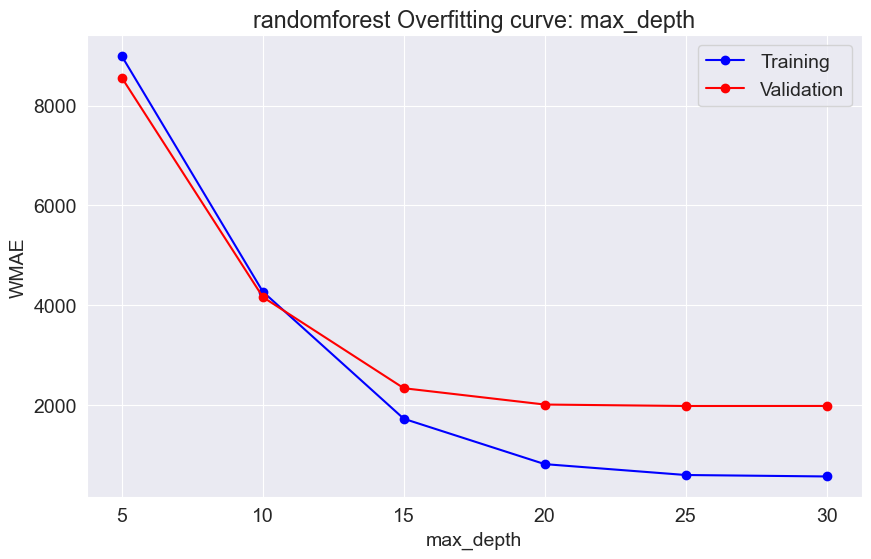

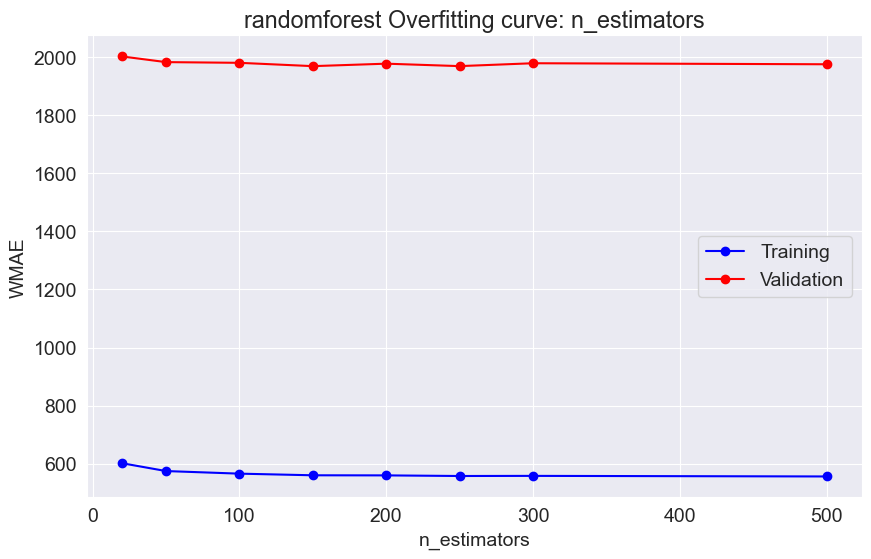

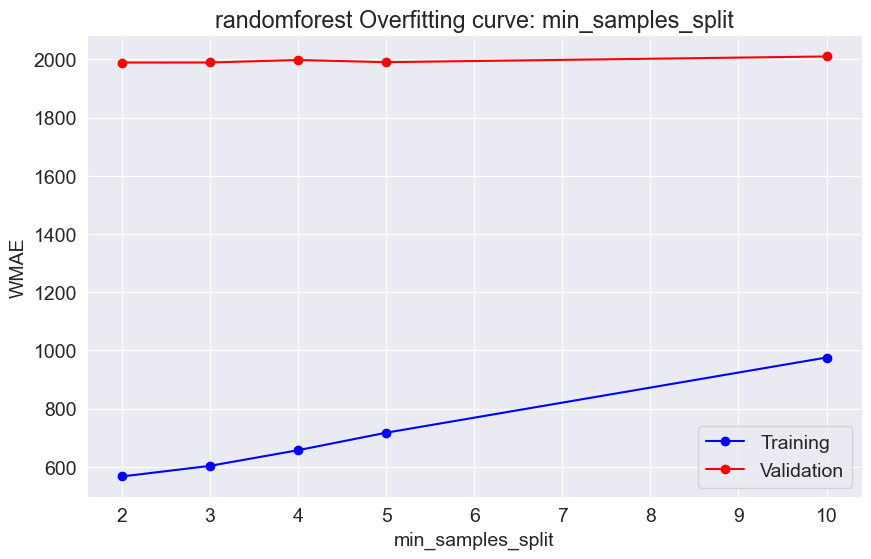

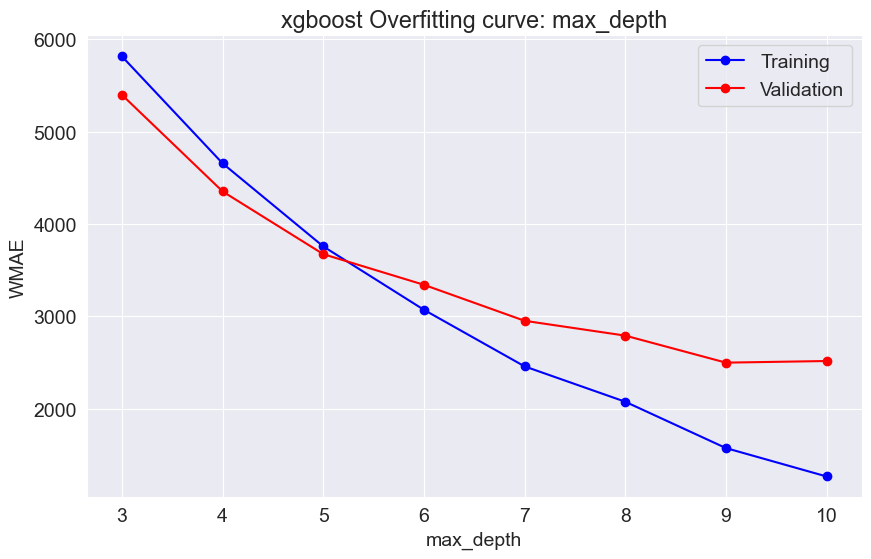

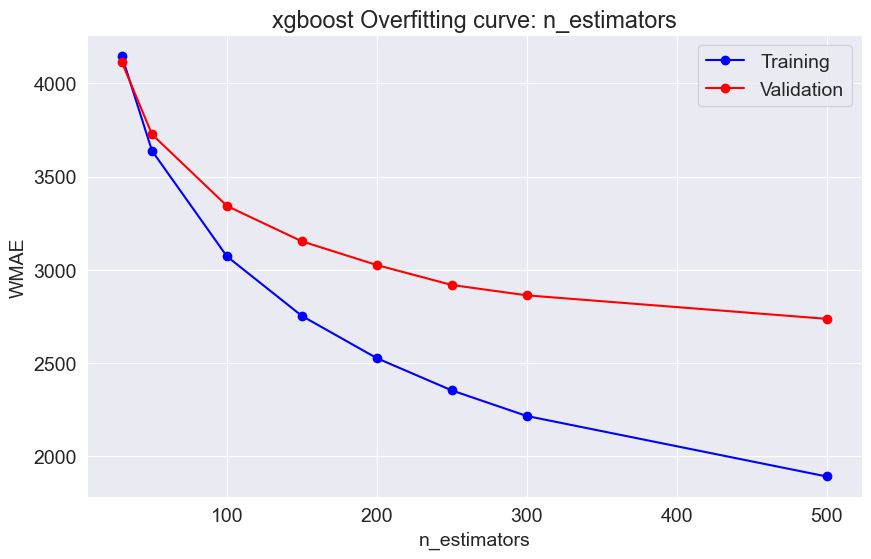

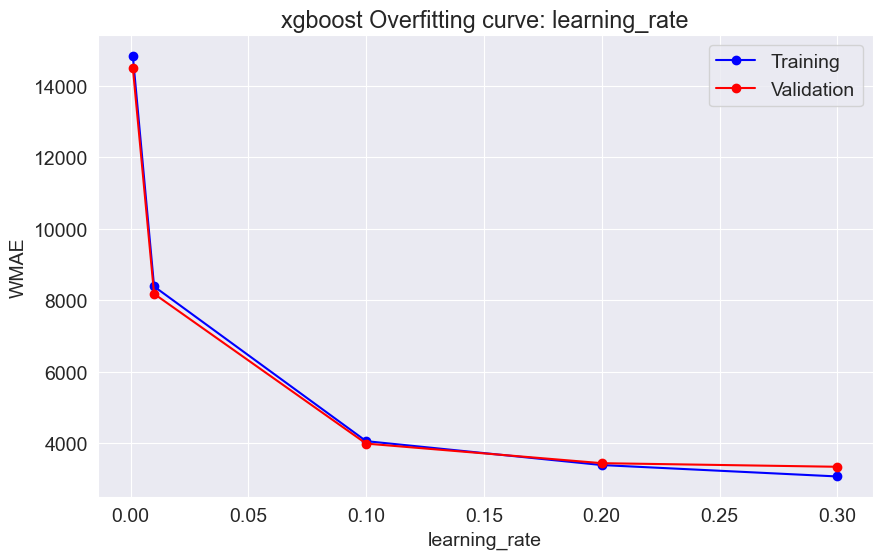

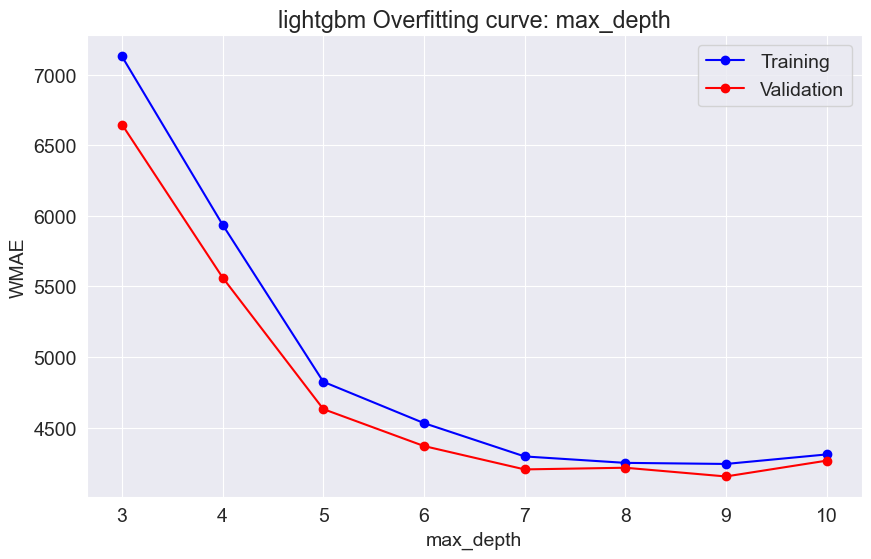

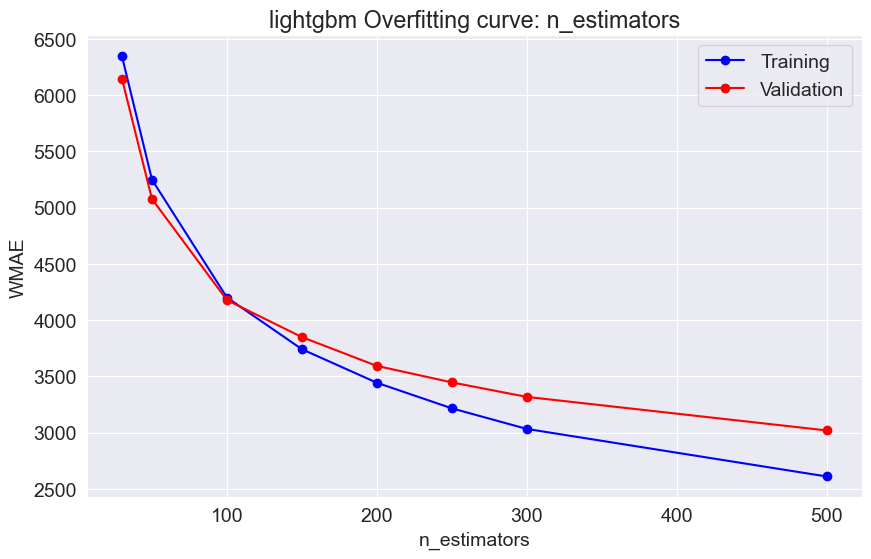

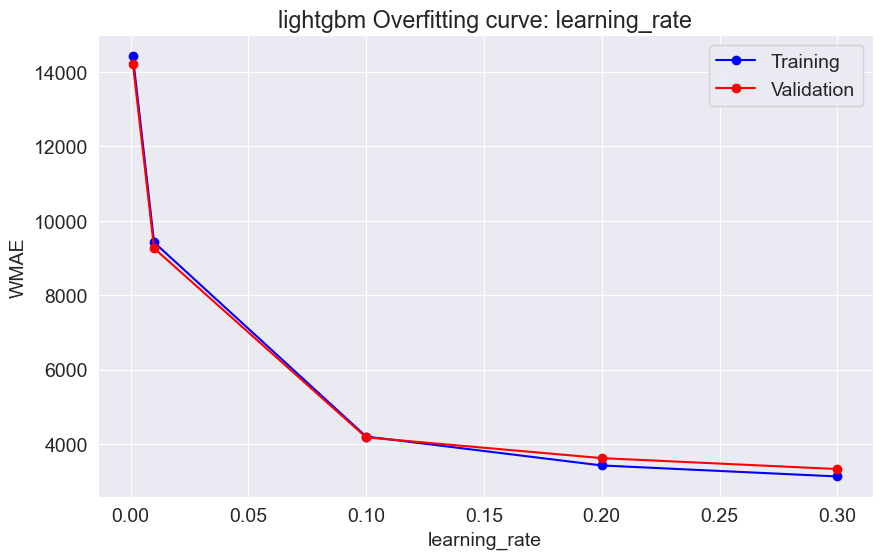

In [464]:
# Iterate over each model type
for model_type, config in models.items():
    model = config['model']
    params = config['params']
    
    # Iterate over each parameter and its values
    for param_name, param_values in params.items():
        wmae_results = test_param_and_plot(model_type, model, param_name, param_values)
        results[model_type] = wmae_results

# 7. Model Selection

From hyperparameter tuning, random forest seems to work the best - it provides the best validation scores ~2000. Further, I used the GridSearchCV to obtain the best fit random forest and xgboost model

In [465]:
from sklearn.model_selection import GridSearchCV

In [466]:
model = RandomForestRegressor(random_state=42, n_jobs=-1)

In [467]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, train_targets)

best_model = grid_search.best_estimator_

scores = cross_val_score(best_model, X_train, train_targets, cv=5, scoring='neg_mean_absolute_error')
wmae_scores = -scores

print("Cross-validation WMAE scores: ", wmae_scores)
print("Mean WMAE: ", np.mean(wmae_scores))

best_model.fit(X_train, train_targets)

print("Validation WMAE")
rf_val_wmae = weighted_mean_absolute_error(val_targets, best_model.predict(X_val), val_weights)

Cross-validation WMAE scores:  [2084.20588859 1801.3954088  2289.6250968  1807.34656699 2494.84223194]
Mean WMAE:  2095.483038623421
Validation WMAE


In [471]:
rf_val_wmae

1984.7730360508367

In [472]:
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)

In [473]:
xgb_param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, train_targets)

xgb_best_model = grid_search.best_estimator_

scores = cross_val_score(xgb_best_model, X_train, train_targets, cv=5, scoring='neg_mean_absolute_error')
xgb_mae_scores = -scores
print("Cross-validation MAE scores:", xgb_mae_scores)
print("Mean MAE:", np.mean(xgb_mae_scores))

xgb_best_model.fit(X_train, train_targets)

print("Validation WMAE")
xgb_val_wmae = weighted_mean_absolute_error(val_targets, xgb_best_model.predict(X_val), val_weights)

Cross-validation MAE scores: [2935.79216268 2625.76383495 3001.69304197 2738.494869   3179.13154636]
Mean MAE: 2896.175090991595
Validation WMAE


2820.2727876636172

In [474]:
xgb_val_wmae

2820.2727876636172

## Saving Trained Models
We can save the parameters (weights and biases) of our trained model to disk, so that we needn't retrain the model from scratch each time we wish to use it. Along with the model, it's also important to save imputers, scalers, encoders and even column names. Anything that will be required while generating predictions using the model should be saved.

We can use the joblib module to save and load Python objects on the disk.

In [475]:
import joblib

walmart_sales = {
    'rf_model':best_model,
    'xgb_model':xgb_best_model,
    'imputer':imputer,
    'scaler':scaler,
    'encoder':encoder,
    'input_cols':input_cols,
    'target_cols':target_col,
    'numeric_cols':numeric_cols,
    'categorical_cols':categorical_cols,
    'encoded_cols':encoded_cols
}

In [476]:
joblib.dump(walmart_sales, 'walmart_sales.joblib')

['walmart_sales.joblib']

# 8. Test Predictions and Submission

In [478]:
test_preds1 = best_model.predict(X_test)
test_preds2 = xgb_best_model.predict(X_test)

In [485]:
submission = pd.read_csv("sampleSubmission.csv", header = 0)
submission['Weekly_Sales'] = test_preds2
submission.fillna(0, inplace=True)
submission.to_csv("submission.csv", index=None)

![Kaggle Submission](https://imgur.com/MsyxfrX.png)

### From the different submissions, Random Forest is the best performing model with n_estimators = 500 and max_depth = 25. Public score of ~4000 puts me in the top 50% of the competition submissions.

# Summary and Conclusions

In this machine learning project, I utilized Walmart stores historical sales data to predict the weekly sales based on data given for 3 years. Since we want to predict a continuous variable, this is an example of a regression problem. The following steps were performed - 

* The dataset was downloaded from kaggle
* Data cleaning and preprocessing was performed (merging, checking for null values)
* Feature engineering was performed - new datetime, markdown and holiday features were applied to the dataset
* Exploratory data analysis was performed - checked for trends with weekly sales
* The data was prepared for model training - train & validation split, identifying numeric and categorical columns, scaling, imputation and encoding
* Several linear models were trained but unfortunately they performed poorly
* Ensemble models were then trained and top three performing models were random forest, xgboost and lightgbm
* Hyperparameter tuning was performed in order to obtain the best fit values
* Model was selected after performing grid search
* The best performing model was random forest.

This project put me in the top 50% of Kaggle submissions. The top submissions employed ARIMA and time series techniques to train the models. This project can be improved by employing time series analysis techniques.

# References & Inspiration

* https://jovian.com/learn/zero-to-data-analyst-bootcamp/lesson/decision-trees-and-random-forests
* https://jovian.com/learn/zero-to-data-analyst-bootcamp/lesson/how-to-approach-machine-learning-problems
* https://jovian.com/learn/zero-to-data-analyst-bootcamp/lesson/gradient-boosting-machines-with-xgboost
* ChatGPT

In [488]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "arames52/walmart-sales-forecasting" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/arames52/walmart-sales-forecasting


'https://jovian.com/arames52/walmart-sales-forecasting'